In [1]:
import os
import shutil
import random
from tqdm import tqdm
from typing import Tuple, List
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def split_dataset_by_class(
    source_dir: str,
    output_base_dir: str,
    split_ratios: Tuple[float, float, float] = (0.9, 0.05, 0.05),
    seed: int = 42
) -> None:
    """
    Splits a dataset organized in class folders into train, valid, and test sets.

    Args:
        source_dir (str): Path to the original dataset with class subfolders.
        output_base_dir (str): Path to the output folder where splits will be saved.
        split_ratios (Tuple[float, float, float], optional): Train, valid, test ratios. Defaults to (0.9, 0.05, 0.05).
        seed (int, optional): Random seed for reproducibility. Defaults to 42.
    """
    assert sum(split_ratios) == 1.0, "Split ratios must sum to 1.0"
    splits = ['Train', 'Valid', 'Test']
    random.seed(seed)

    # Create split folders
    for split in splits:
        for class_name in os.listdir(source_dir):
            class_dir = os.path.join(source_dir, class_name)
            if os.path.isdir(class_dir):
                split_class_dir = os.path.join(output_base_dir, split, class_name)
                os.makedirs(split_class_dir, exist_ok=True)

    # Process each class
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', 'jpeg', '.png'))]
        total = len(images)
        random.shuffle(images)

        train_end = int(split_ratios[0] * total)
        valid_end = train_end + int(split_ratios[1] * total)

        split_data = {
            'Train': images[:train_end],
            'Valid': images[train_end:valid_end],
            'Test': images[valid_end:]
        }

        for split in splits:
            for img_name in tqdm(split_data[split], desc=f"Copying {split} images for '{class_name}'"):
                src = os.path.join(class_path, img_name)
                dst = os.path.join(output_base_dir, split, class_name, img_name)
                shutil.copyfile(src, dst)

    print("\n Dataset split completed!")

In [3]:
split_dataset_by_class(
    source_dir='data',
    output_base_dir='maize_leaf_split_dataset',
    split_ratios=(0.9, 0.05, 0.05)
)

Copying Train images for 'Blight':   0%|          | 0/1031 [00:00<?, ?it/s]

Copying Test images for 'Healthy': 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 59/59 [00:00<00:00, 123.03it/s]


 Dataset split completed!


In [2]:
# Step 1: Check the Distribution of Images Across Classes
def get_class_distribution(path):
    """
    Get the distribution of images across different classes.

    Args:
        path (str): Path to the dataset folder (train/valid/test).

    Returns:
        dict: Dictionary with class names as keys and number of images as values.
    """
    class_counts = {}
    for class_folder in os.listdir(path):
        class_folder_path = os.path.join(path, class_folder)
        if os.path.isdir(class_folder_path):
            num_images = len(os.listdir(class_folder_path))
            class_counts[class_folder] = num_images
    return class_counts

In [6]:
dataset_path = 'maize_leaf_split_dataset'
train_distribution = get_class_distribution(dataset_path + '/Train')
valid_distribution = get_class_distribution(dataset_path + '/Valid')
test_distribution = get_class_distribution(dataset_path + '/Test')

print("Training Set Distribution:")
print(train_distribution)
print("\nValidation Set Distribution:")
print(valid_distribution)
print("\nTest Set Distribution:")
print(test_distribution)

Training Set Distribution:
{'Blight': 1031, 'Common_Rust': 1175, 'Gray_Leaf_Spot': 516, 'Healthy': 1045}

Validation Set Distribution:
{'Blight': 57, 'Common_Rust': 65, 'Gray_Leaf_Spot': 28, 'Healthy': 58}

Test Set Distribution:
{'Blight': 58, 'Common_Rust': 66, 'Gray_Leaf_Spot': 30, 'Healthy': 59}


In [7]:
# Step 2: Visualize Samples
def visualize_samples(path, num_samples=3):
    """
    Visualize a few sample images from each class.

    Args:
        path (str): Path to the dataset folder (train/test).
        num_samples (int): Number of samples to visualize per class.
    """
    for class_folder in os.listdir(path):
        class_folder_path = os.path.join(path, class_folder)
        if os.path.isdir(class_folder_path):
            print(f"\nClass: {class_folder}")
            images = os.listdir(class_folder_path)
            available_samples = min(len(images), num_samples)
            if available_samples == 0:
                print("No images found in this class.")
                continue

            sample_images = random.sample(images, available_samples)

            # Handle single or multiple subplots
            if available_samples == 1:
                fig, ax = plt.subplots(1, 1, figsize=(3, 3))
                img_path = os.path.join(class_folder_path, sample_images[0])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(class_folder)
            else:
                fig, axes = plt.subplots(1, available_samples, figsize=(15, 5))
                for i, img_name in enumerate(sample_images):
                    img_path = os.path.join(class_folder_path, img_name)
                    img = Image.open(img_path)
                    axes[i].imshow(img)
                    axes[i].axis('off')
                    axes[i].set_title(class_folder)
            plt.show()


Class: Blight


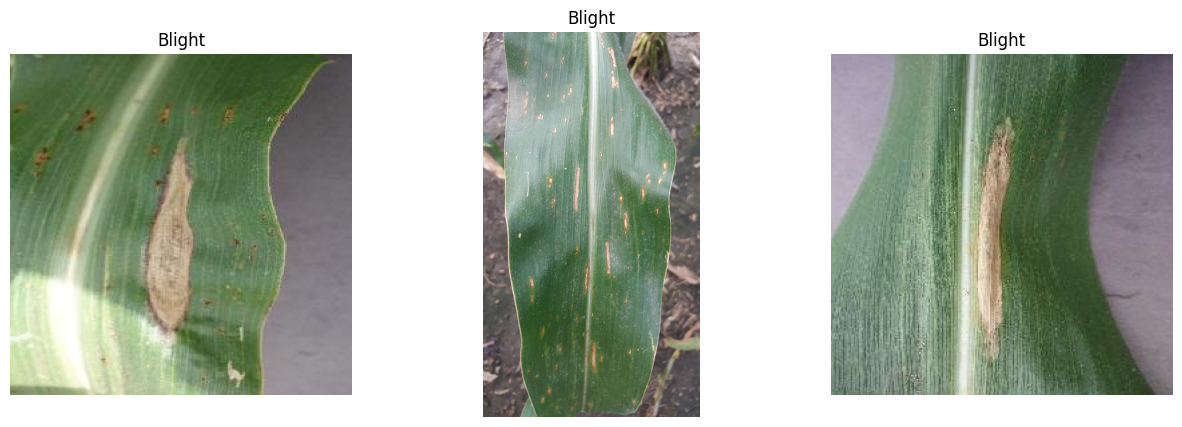


Class: Common_Rust


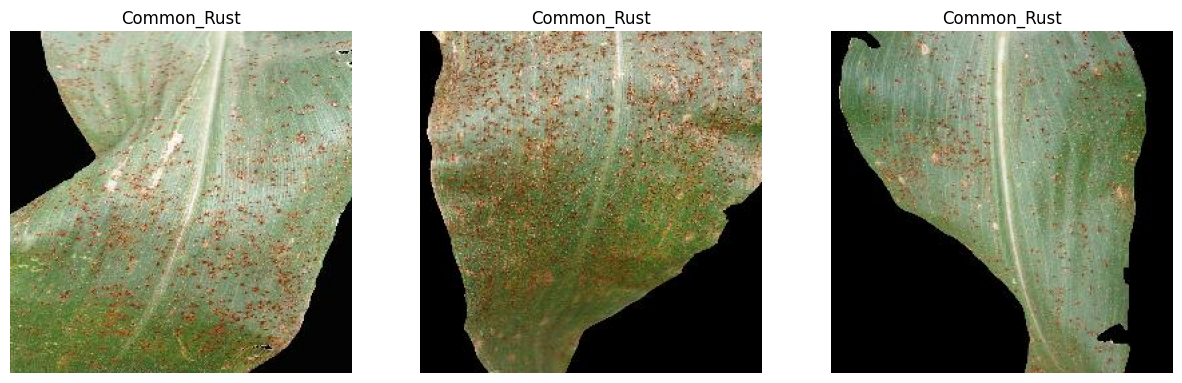


Class: Gray_Leaf_Spot


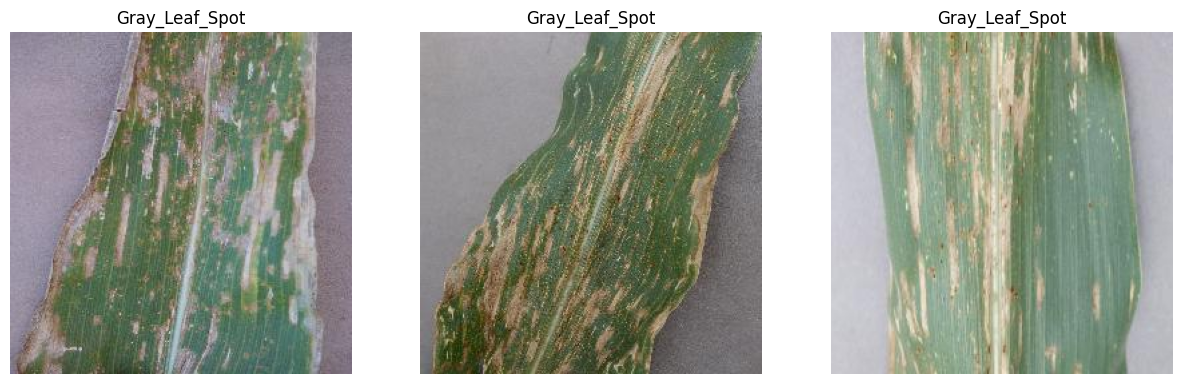


Class: Healthy


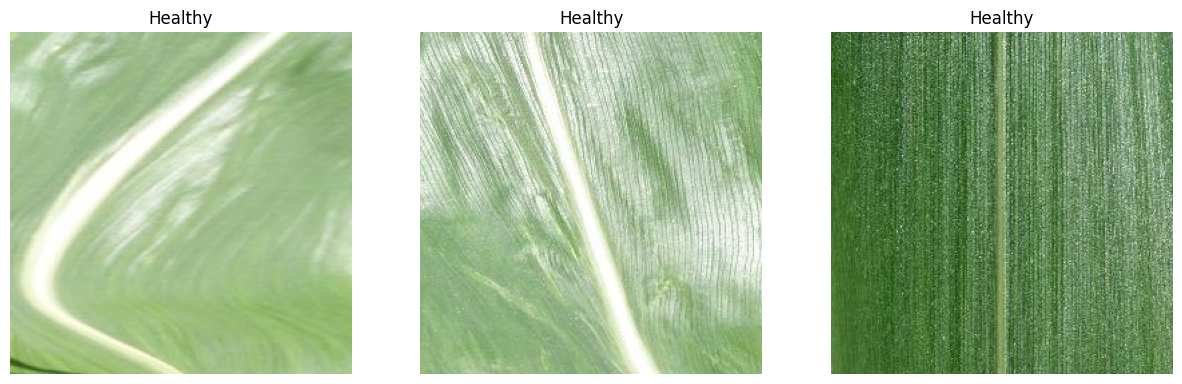

In [8]:
# Visualize samples from training set
visualize_samples(dataset_path + '/Train')

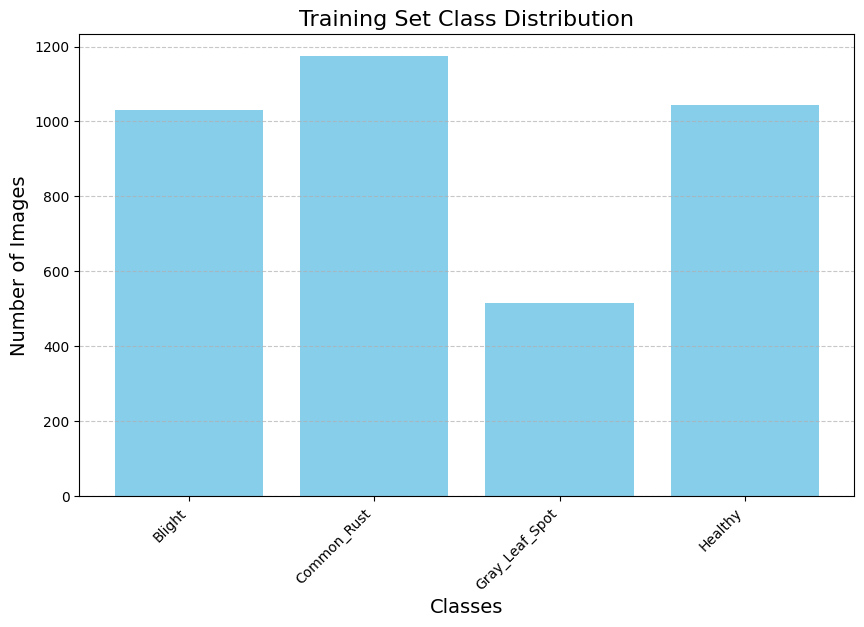

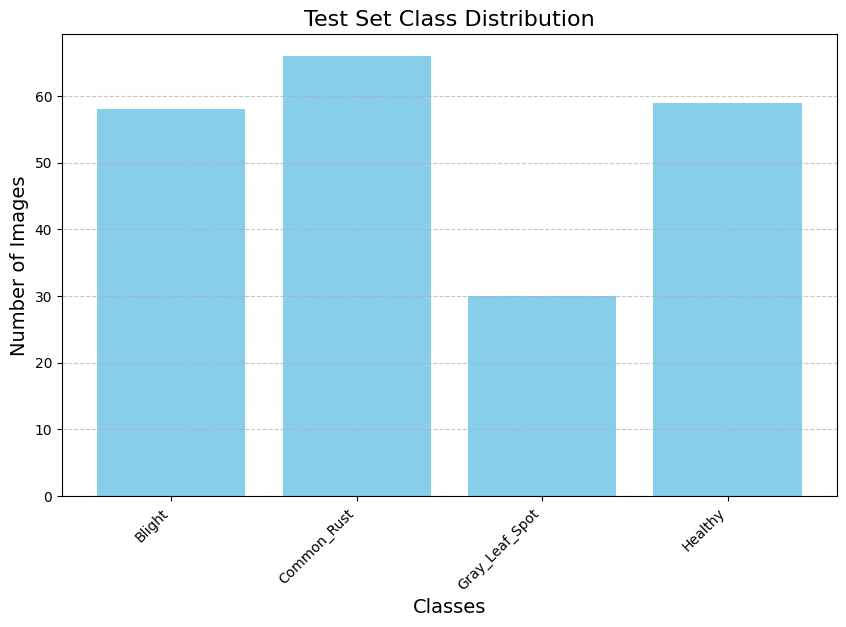

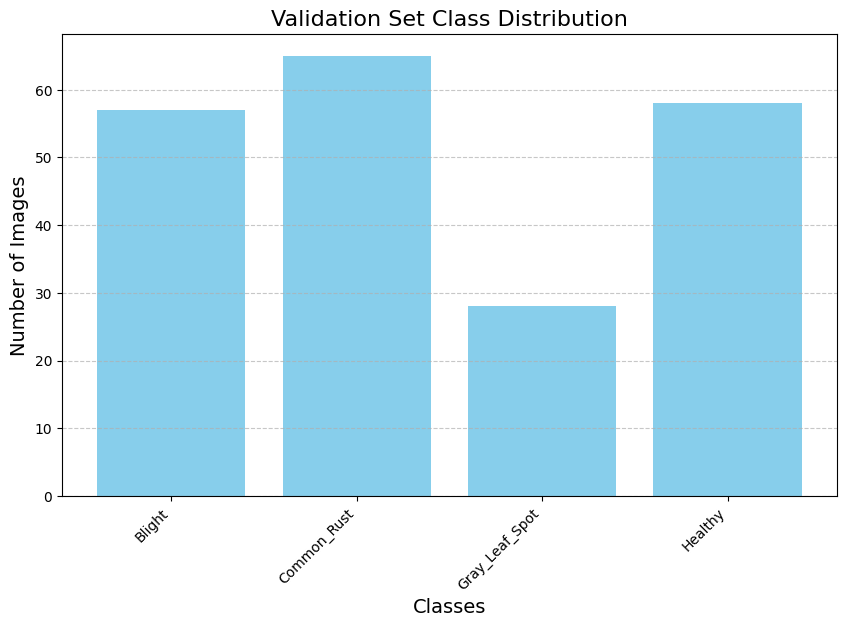

In [9]:
def plot_class_distribution(distribution, title):
    """
    Plot a bar chart for class distribution.

    Args:
        distribution (dict): Dictionary with class names as keys and image counts as values.
        title (str): Title of the chart.
    """
    classes = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show
# Plot for training set
plot_class_distribution(train_distribution, "Training Set Class Distribution")

# Plot for test set
plot_class_distribution(test_distribution, "Test Set Class Distribution")

# Plot for validation set
plot_class_distribution(valid_distribution, "Validation Set Class Distribution")

In [13]:
def drop_images(class_folder, keep_count):
    images = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(images)

    if current_count <= keep_count:
        print(f"Class '{os.path.basename(class_folder)}' already has {current_count} images (<= {keep_count}). No images dropped.")
        return

    drop_count = current_count - keep_count
    images_to_drop = random.sample(images, drop_count)

    for img_name in images_to_drop:
        img_path = os.path.join(class_folder, img_name)
        os.remove(img_path)

    print(f"Dropped {drop_count} images from class: '{os.path.basename(class_folder)}'. Retained {keep_count} images.")

# Run this to balance each class in the training set to 515 images
train_path = 'maize_leaf_split_dataset/Train'
keep_count = 515

for class_name in os.listdir(train_path):
    class_folder = os.path.join(train_path, class_name)
    if os.path.isdir(class_folder):
        drop_images(class_folder, keep_count)


Dropped 516 images from class: 'Blight'. Retained 515 images.
Dropped 660 images from class: 'Common_Rust'. Retained 515 images.
Dropped 1 images from class: 'Gray_Leaf_Spot'. Retained 515 images.
Dropped 18 images from class: 'Healthy'. Retained 515 images.


In [15]:
print("\nUpdated Training Set Distribution:")
print(get_class_distribution(train_path))


Updated Training Set Distribution:
{'Blight': 515, 'Common_Rust': 515, 'Gray_Leaf_Spot': 515, 'Healthy': 515}


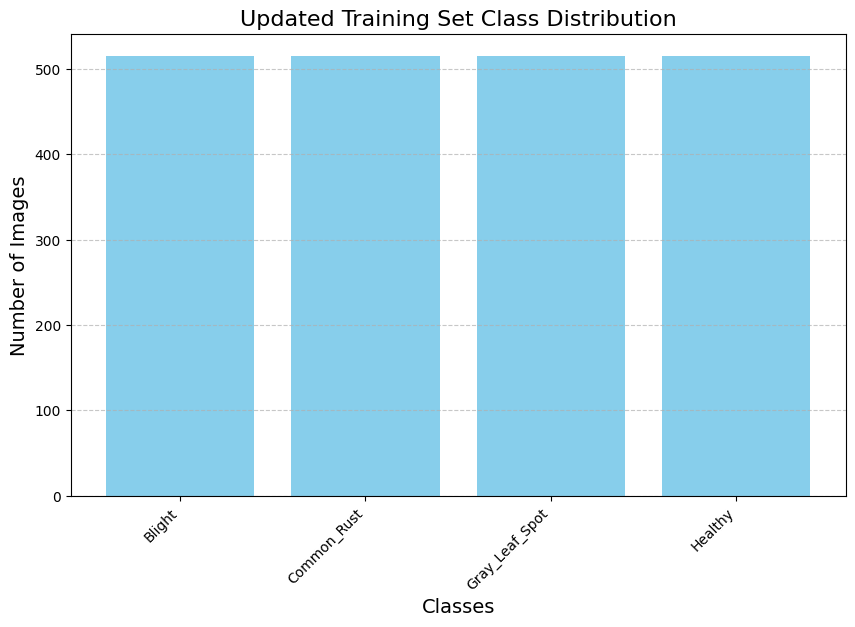

In [16]:
plot_class_distribution(get_class_distribution(train_path), "Updated Training Set Class Distribution")

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [3]:
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))
print("Number of GPUs:", torch.cuda.device_count())

CUDA available: True
GPU Name: NVIDIA GeForce GTX 1050
Number of GPUs: 1


In [4]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225]
                                                          )])

test_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

train_dir = 'maize_leaf_split_dataset/Train'
test_dir = 'maize_leaf_split_dataset/Test'
valid_dir = 'maize_leaf_split_dataset/Valid'


# Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform = train_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform = test_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform = valid_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = DataLoader(train_datasets, batch_size=16, shuffle=True)
testloader = DataLoader(test_datasets, batch_size=8)
validloader = DataLoader(valid_datasets, batch_size=8)

In [20]:
!pip install transformers

   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.4 MB 2.2 MB/s eta 0:00:05
   ----- ---------------------------------- 1.3/10.4 MB 3.2 MB/s eta 0:00:03
   ------- -------------------------------- 1.8/10.4 MB 3.8 MB/s eta 0:00:03
   ----------- ---------------------------- 2.9/10.4 MB 4.1 MB/s eta 0:00:02
   ------------- -------------------------- 3.4/10.4 MB 3.8 MB/s eta 0:00:02
   ---------------- ----------------------- 4.2/10.4 MB 3.4 MB/s eta 0:00:02
   ------------------- -------------------- 5.0/10.4 MB 3.5 MB/s eta 0:00:02
   --------------------- ------------------ 5.5/10.4 MB 3.4 MB/s eta 0:00:02
   ---------------------- ----------------- 5.8/10.4 MB 3.3 MB/s eta 0:00:02
   ------------------------ --------------- 6.3/10.4 MB 3.1 MB/s eta 0:00:02
   ------------------------- -------------- 6.6/10.4 MB 2.9 MB/s eta 0:00:02
   ----------


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
torch.cuda.memory._record_memory_history()

In [5]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Load model with custom classifier head
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(train_datasets.classes),
    ignore_mismatched_sizes=True
)

c:\Users\ACER NITRO 5\Desktop\Capstone Project\capstone_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Set the VIT model
model


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
device

device(type='cuda')

In [8]:
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer
for param in model.classifier.parameters():
    param.requires_grad = True

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [10]:
import wandb

wandb.init(
    project="maize-leaf-disease-identification",  
    name="vit-training-run",                 
    config={
        "epochs": 20,
        "batch_size": 16,
        "optimizer": "Adam",
        "architecture": "ViT-base-patch16-224"
    }
)

wandb: Currently logged in as: ufee (ufee-gsu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
model.to(device)
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_loss /= len(trainloader)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total

    # üîé Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_loss /= len(validloader)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })


Epoch 1/20 | Train Loss: 0.0016 | Train Acc: 79.76% | Val Loss: 0.0054 | Val Acc: 81.73%
Epoch 2/20 | Train Loss: 0.0019 | Train Acc: 88.88% | Val Loss: 0.0067 | Val Acc: 89.90%
Epoch 3/20 | Train Loss: 0.0034 | Train Acc: 90.49% | Val Loss: 0.0034 | Val Acc: 91.35%
Epoch 4/20 | Train Loss: 0.0025 | Train Acc: 90.87% | Val Loss: 0.0048 | Val Acc: 91.35%
Epoch 5/20 | Train Loss: 0.0016 | Train Acc: 90.87% | Val Loss: 0.0026 | Val Acc: 91.35%
Epoch 6/20 | Train Loss: 0.0006 | Train Acc: 91.31% | Val Loss: 0.0049 | Val Acc: 92.31%
Epoch 7/20 | Train Loss: 0.0005 | Train Acc: 92.67% | Val Loss: 0.0017 | Val Acc: 91.35%
Epoch 8/20 | Train Loss: 0.0005 | Train Acc: 93.06% | Val Loss: 0.0033 | Val Acc: 92.79%
Epoch 9/20 | Train Loss: 0.0019 | Train Acc: 92.67% | Val Loss: 0.0036 | Val Acc: 92.79%
Epoch 10/20 | Train Loss: 0.0039 | Train Acc: 91.60% | Val Loss: 0.0020 | Val Acc: 91.35%
Epoch 11/20 | Train Loss: 0.0019 | Train Acc: 93.69% | Val Loss: 0.0050 | Val Acc: 91.83%
Epoch 12/20 | Train

In [13]:
model_save_path = 'saved_model/vit_maize_leaf_identifier.pth'
torch.save(model.state_dict(), model_save_path)

In [19]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


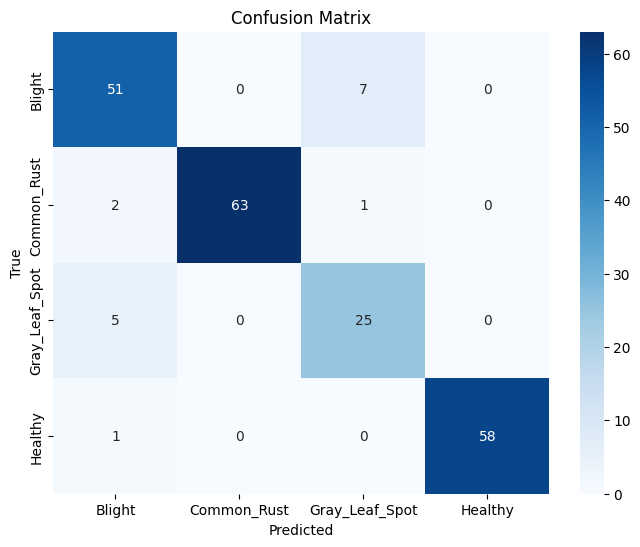


Classification Report:
                precision    recall  f1-score   support

        Blight       0.86      0.88      0.87        58
   Common_Rust       1.00      0.95      0.98        66
Gray_Leaf_Spot       0.76      0.83      0.79        30
       Healthy       1.00      0.98      0.99        59

      accuracy                           0.92       213
     macro avg       0.91      0.91      0.91       213
  weighted avg       0.93      0.92      0.93       213

ROC-AUC Score (OvR): 0.9864


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs.logits, dim=1)

        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Get class names
class_names = test_datasets.classes

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ROC-AUC Score (One-vs-Rest for Multiclass)
try:
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
    print(f"ROC-AUC Score (OvR): {roc_auc:.4f}")
except ValueError:
    print("ROC-AUC could not be calculated (might need more than one class in test batch).")
